In [5]:
import requests
import json
from pandas.io.json import json_normalize 
import os
import csv
import pandas as pd


In [13]:
#Array for years with significant rule changes 
signrules = ['1976','1989','1993','1994','1995','2009','2014']
print(signrules)

['1976', '1989', '1993', '1994', '1995', '2009', '2014']


In [15]:
filname = "myf1data.csv"
#Delete the CSV file if it already exists
if os.path.exists(filname):
  os.remove(filname)


#Load data into myf1data.csv
#Get the data from the JSON output.  Since the Diver and Constructor sections are lists
# of dictionaries, I had to normalize it and retrieve each one seperately
# The logic below retrieves the necessary field 
#Posittion, Race Name, Season/Year, Race Number, Race Date, DriverFirstName, DriverLastName, DriverID, StartingGrid#,ConstructorName
with open(filname, 'a', newline='\n') as csvfile:
    csvwriter = csv.writer(csvfile)
    fieldnames = ['Posittion','RaceName','SeasonYear','RaceNumber','RaceDate','DriverFirstName',
                'DriverLastName','DriverID','StartingGridNumb','ConstructorName','RaceTime','rulechanges']
    csvwriter.writerow(fieldnames)
def load_into_csv(link, year,result):
    r = requests.get(link)
    data = r.json()
    r.close()
    data_df =data['MRData']['RaceTable']
    with open(filname, 'a', newline='\n') as csvfile:
#csvwriter.writerow(['Posittion','RaceName','SeasonYear','RaceNumber','RaceDate','DriverFirstName','DriverLastName','DriverID','StartingGridNumb','ConstructorName'])
   
        for f1dat in [data_df]:
            for races in f1dat['Races']:
                for results in races['Results']:
                     for givenname in json_normalize(results['Driver'])['givenName']:
 
                         for famname in json_normalize(results['Driver'])['familyName']:
                            for driverid in json_normalize(results['Driver'])['driverId']:
                                for construct in json_normalize(results['Constructor'])['name']:
                                    
                                #Used the logic below to account for missing time values. Created a pseudo dictionary to account for blanks.
                                    times = results.get('Time',{'millis': '0', 'time': '0'})

                                    racetime =times.get('time',0)
                                    #Add rule changes field for years with significant changes 1 = Yes  0 = NO
                                    if  races['season'] in signrules:
                                        rulechanges = 1
                                    else:
                                        rulechanges = 0
                                    
                                    data = [f1dat['position'],races['raceName'],races['season'],races['round'] ,
                                                races['date'],givenname, famname,driverid,results['grid'],construct, racetime, rulechanges]

                            
                                    csvwriter = csv.writer(csvfile)
                                    csvwriter.writerow(data)

                                    
    csvfile.close()


if __name__ == "__main__":

    
    result = '1'
# We only want data for the top 3 spots per race
    while int(result) <= 3:
        #We can filter by year below
        year='1970'
        while int(year) <= 2018:
           
            link = 'https://ergast.com/api/f1/' + year + '/results/'+ result +'.json'
            load_into_csv(link, year,result)
            year = str(int(year)+1)

        link = 'https://ergast.com/api/f1/' + year + '/results/'+ result +'.json'
        load_into_csv(link, year,result)
           
        result = str(int(result)+1)
        

 

In [32]:
#Import data as Pandas

import pandas as pd 

data = pd.read_csv(filname,encoding = "ISO-8859-1") 


data.head()

,Posittion,RaceName,SeasonYear,RaceNumber,RaceDate,DriverFirstName,DriverLastName,DriverID,StartingGridNumb,ConstructorName,RaceTime,rulechanges
0,1,South African Grand Prix,1970,1,1970-03-07,Jack,Brabham,jack_brabham,3,Brabham,1:49:35.4,0
1,1,Spanish Grand Prix,1970,2,1970-04-19,Jackie,Stewart,stewart,3,March,2:10:58.2,0
2,1,Monaco Grand Prix,1970,3,1970-05-10,Jochen,Rindt,rindt,8,Team Lotus,1:54:37.4,0
3,1,Belgian Grand Prix,1970,4,1970-06-07,Pedro,Rodríguez,rodriguez,6,BRM,1:38:10.1,0
4,1,Dutch Grand Prix,1970,5,1970-06-21,Jochen,Rindt,rindt,1,Team Lotus,1:50:43.4,0


In [ ]:
#Now we need to add the rule changes data
#First I'll scrape this WikiPedia page for rule changes by year:
#https://en.wikipedia.org/wiki/History_of_Formula_One_regulations

In [17]:
from bs4 import BeautifulSoup
import requests

page = requests.get("https://en.wikipedia.org/wiki/History_of_Formula_One_regulations")
soup = BeautifulSoup(page.content, 'html.parser')
[s.extract() for s in soup('sup')] #Remove hyperlinks (sup)
data = soup.find(id="content")
yearsall = data.find_all('dt')
rulechall = data.find_all('dd')
rulech = rulechall[50]
year = yearsall[50]
print(rulech.prettify())
print(year.prettify())
#sample output below

<dd>
 New car formula of turbocharged V6 engines with 1600cc capacity and 8-speed gearbox introduced,
 which must now last at least 4,000 km (2,500 mi) before being replaced
 and have the KERS (now known as ERS-K) integrated into it.
 New penalty points system introduced, teams must nominate eight gear ratios ahead of the first race, false camera mountings banned, in-season testing returns, car nose further reprofiled. A new car number system where the driver is able to choose their own numbers for the duration of their career is also adopted. Double points awarded for the final race of the season.
</dd>
<dt>
 2014
</dt>



In [18]:
# Retrieve data sets for year and details (of changes)
yearsdata = [sd.get_text() for sd in data.select('dt')]
detailsdata = [t.get_text() for t in data.select('dd')]


In [20]:
#Create panda table of our data 
rulechangesdata = pd.DataFrame({
        "year": yearsdata, 
        "details": detailsdata
    })
rulechangesdata.head()

,details,year
0,Engine specs set at 1500 cc maximum size for e...,1950–1953
1,Engine specs amended to allow 750 cc maximum e...,1954
2,The use of commercial petrol became compulsory...,1958
3,Regulations unchanged from 1959 (maximum engin...,1960
4,Engine specs amended to a naturally aspirated ...,1961–1965


In [ ]:
# Now that I have my data set and my rules in one place,
# time to do the part I was avoiding, go through the rules
# to choose which years had 'BIG' changes.

In [ ]:
# After subjectively going through the list, the following looked to have 
#significant changes.
#1976,1989,,1993,,1994,1995,2009,2014 


In [ ]:
# We will also need the actual Construction and Driver Championship winners per year

In [ ]:
#Let's practice webscraping again and using Wikipedia champinship data

In [21]:
champpage = requests.get("https://simple.wikipedia.org/wiki/List_of_Formula_One_World_Drivers%27_Champions")
champsoup = BeautifulSoup(champpage.content, 'html.parser')
[s.extract() for s in champsoup('href')] #Remove hyperlinks (sup)
champdata = champsoup.find(id="content")


In [25]:
champstable = champsoup.find('table',{'class':'wikitable sortable'})

In [26]:
[s.extract() for s in champsoup('span')] #Remove hyperlinks (span) this was causing issues with the name since there are 2 'a's


[]

In [27]:

#creating lists for each of the columns I know to be in my table.
A=[]
B=[]
C=[]
D=[]
E=[]
F=[]
#utilizing HTML tags for rows <tr> and elements <td> to iterate through each row of data and append data elements to their appropriate lists:
for row in champstable.findAll('tr'):
    cells = row.findAll('td')
    driver = row.find_all('a')
    if len(cells)==10: # Number of columns in table
        A.append(cells[0].find(text=True))
        B.append(driver[1].find(text=True))
        C.append(cells[2].find(text=True))
        D.append(cells[3].find(text=True))
        E.append(cells[4].find(text=True))
        F.append(cells[5].find(text=True))

In [28]:
champsdf=pd.DataFrame(A,columns=['Season'])
champsdf['Driver']=B
champsdf['Team']=C
champsdf['Poles']=D
champsdf['Wins']=E
champsdf['Podiums']=F

champsdf.head()

#Now we have summarized championship figures 

,Season,Driver,Team,Poles,Wins,Podiums
0,1950,Nino Farina,Alfa Romeo,2,3,3
1,1951,Juan Manuel Fangio,Alfa Romeo,4,3,5
2,1952,Alberto Ascari,Ferrari,5,6,6
3,1953,Alberto Ascari,Ferrari,6,5,5
4,1954,Juan Manuel Fangio,Maserati,5,6,7


In [58]:
#Add rule changes column/field to our wikipedia data frames
champsdf['Big Rule Changes'] = champsdf.apply(lambda x: 1 if x['Season'] in signrules  else 0, axis=1)
champsdf.head()


rulechangesdata['year'] = rulechangesdata['year'].str.strip() #Clean spaces in year
rulechangesdata['Big Rule Changes'] = rulechangesdata.apply(lambda x: 1 if x['year'] in signrules  else 0, axis=1)

rulechangesdata.head()

,details,year,Big Rule Changes
0,Engine specs set at 1500 cc maximum size for e...,1950–1953,0
1,Engine specs amended to allow 750 cc maximum e...,1954,0
2,The use of commercial petrol became compulsory...,1958,0
3,Regulations unchanged from 1959 (maximum engin...,1960,0
4,Engine specs amended to a naturally aspirated ...,1961–1965,0


In [57]:
#The code below witll export our F1 Data, champtionship, and rules data into one 
# Excel workbook (can't help it I love Excel).

with pd.ExcelWriter('f1dataExcel.xlsx') as writer:
    data.to_excel(writer, 'f1data')
    champsdf.to_excel(writer, 'champs')
    rulechangesdata.to_excel(writer, 'Rules', columns = ['year', 'details','Big Rule Changes'])
writer.save()

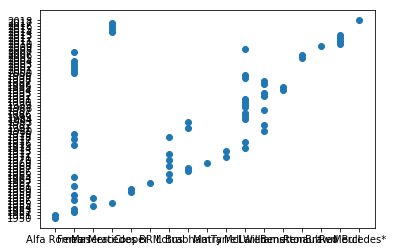

In [60]:
#First chart with our data!
import matplotlib.pyplot  as plt

plt.scatter(x=champsdf['Team'], y=champsdf['Season'])
plt.show()

In [ ]:

plt.scatter(x=champsdf['Team'], y=champsdf['Season'])
plt.show()

In [ ]:
#I think this is when we move on to Tableau.  